# **Amazon Network Analysis**

1. Each node represents an anonymized facebook user that belongs to one of those ten friends lists.

2. Each edge corresponds to the friendship of two facebook users that belong to this network. In other words, two users must become friends on facebook in order for them to be connected in the particular network.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint

The edges are loaded from the data folder and saved in a dataframe. Each edge is a new row and for each edge there is a start_node and an end_node column

In [2]:
amazon = pd.read_csv(
    "Amazon0302.txt",
    sep="\t",
    names=["start_node", "end_node"],
)
amazon

start_node  end_node
0                 0         1
1                 0         2
2                 0         3
3                 0         4
4                 0         5
...             ...       ...
1234872      262110    262099
1234873      262110    262100
1234874      262110    262101
1234875      262110    262106
1234876      262110    262107

[1234877 rows x 2 columns]

The graph is created from the facebook dataframe of the edges:

In [3]:
G = nx.from_pandas_edgelist(amazon, "start_node", "end_node")

In [4]:
for i in range(5001, 262111):
    G.remove_node(i)

# Visualizing the graph
Let’s start our exploration by visualizing the graph. Visualization plays a central role in exploratory data analysis to help get a qualitative feel for the data.

Since we don’t have any real sense of structure in the data, let’s start by viewing the graph with random_layout, which is among the fastest of the layout functions.

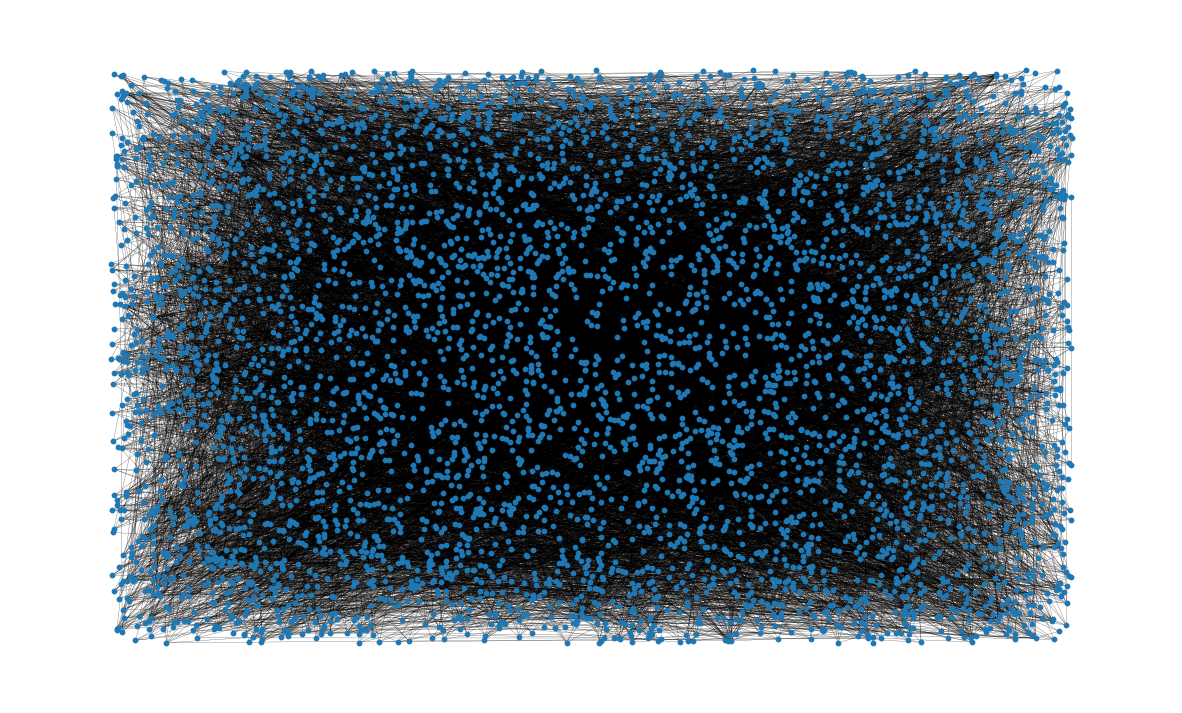

In [5]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

The resulting image is… not very useful. Graph visualizations of this kind are sometimes colloquially referred to as “hairballs” due to the overlapping edges resulting in an entangled mess.

It’s clear that we need to impose more structure on the positioning of the if we want to get a sense for the data. For this, we can use the spring_layout function which is the default layout function for the networkx drawing module. The spring_layout function has the advantage that it takes into account the nodes and edges to compute locations of the nodes. The downside however, is that this process is much more computationally expensive, and can be quite slow for graphs with 100’s of nodes and 1000’s of edges.

Since our dataset has over 80k edges, we will limit the number of iterations used in the spring_layout function to reduce the computation time. We will also save the computed layout so we can use it for future visualizations.

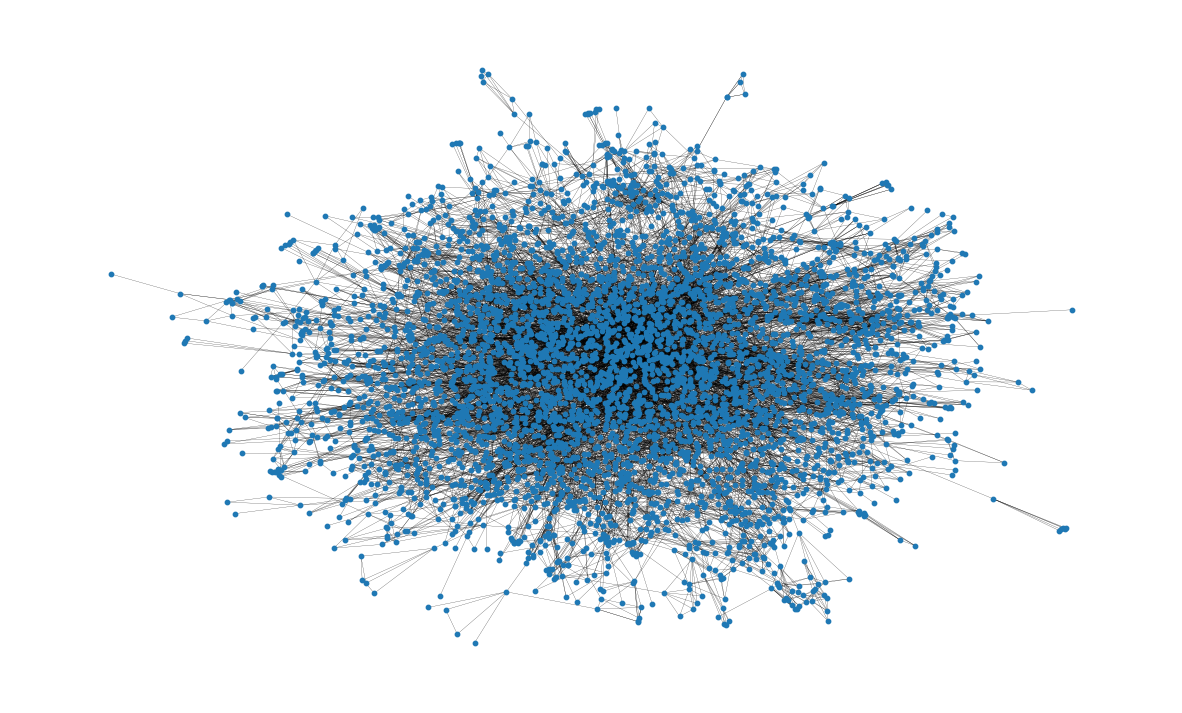

In [6]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

This visualization is much more useful than the previous one! Already we can glean something about the structure of the network; for example, many of the nodes seem to be highly connected, as we might expect for a social network. We also get a sense that the nodes tend to form clusters. The spring_layout serves to give a qualitative sense of clustering, but it is not designed for repeatable, qualitative clustering analysis. 

# Basic topological attributes
- Total number of nodes in network:

In [7]:
G.number_of_nodes()

5001

- Total number of edges:

In [8]:
G.number_of_edges()

14981

Also, the average degree of a node can be seen.

-  On average, a node is connected to almost 44 other nodes, also known as neighbors of the node.

- This has been calculated by creating a list of all the degrees of the nodes and using numpy.array to find the mean of the created list.

In [9]:
np.mean([d for _, d in G.degree()])

5.99120175964807

There are many interesting properties related to the distribution of paths through the graph. For example, the diameter of a graph represents the longest of the shortest-paths that connect any node to another node in the Graph. Similarly, the average path length gives a measure of the average number of edges to be traversed to get from one node to another in the network. These attributes can be calculated with the nx.diameter and nx.average_shortest_path_length functions, respectively. Note however that these analyses require computing the shortest path between every pair of nodes in the network: this can be quite expensive for networks of this size! Since we’re interested in several analyses involving the shortest path length for all nodes in the network, we can instead compute this once and reuse the information to save computation time.

Let’s start by computing the shortest path length for all pairs of nodes in the network:

In [10]:
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

nx.all_pairs_shortest_path_length returns a dict-of-dict that maps a node u to all other nodes in the network, where the inner-most mapping returns the length of the shortest path between the two nodes. In other words, shortest_path_lengths[u][v] will return the shortest path length between any two pair of nodes u and v:

In [11]:
shortest_path_lengths[0][42]  # Length of shortest path between nodes 0 and 42

3

Now let’s use shortest_path_lengths to perform our analyses, starting with the diameter of G. If we look carefully at the docstring for nx.diameter, we see that it is equivalent to the maximum eccentricity of the graph. It turns out that nx.eccentricity has an optional argument sp where we can pass in our pre-computed shortest_path_lengths to save the extra computation:

In [12]:
# This is equivalent to `diameter = nx.diameter(G), but much more efficient since we're
# reusing the pre-computed shortest path lengths!
diameter = max(nx.eccentricity(G, sp=shortest_path_lengths).values())
diameter

19

In [13]:
# Compute the average shortest path length for each node
average_path_lengths = [
    np.mean(list(spl.values())) for spl in shortest_path_lengths.values()
]
# The average over all nodes
np.mean(average_path_lengths)

7.149868086770567

Text(0, 0.5, 'Frequency (%)')

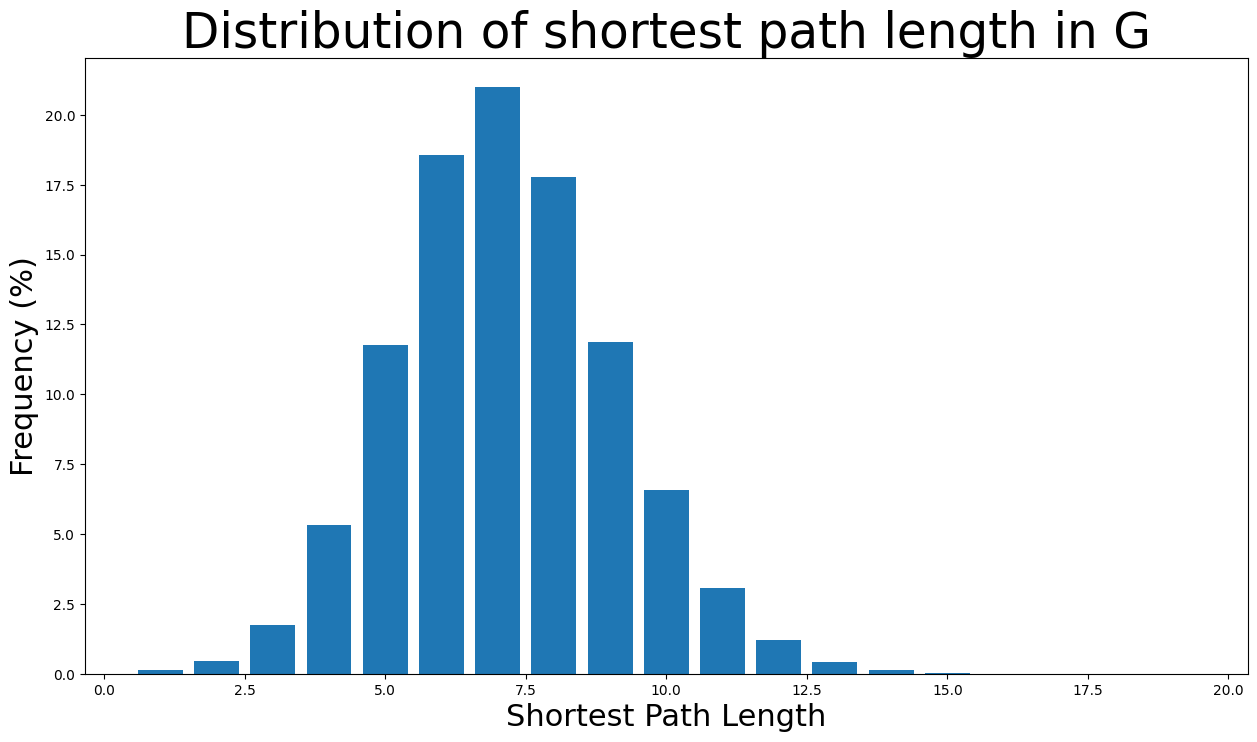

In [14]:
# We know the maximum shortest path length (the diameter), so create an array
# to store values from 0 up to (and including) diameter
path_lengths = np.zeros(diameter + 1, dtype=int)

# Extract the frequency of shortest path lengths between two nodes
for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts

# Express frequency distribution as a percentage (ignoring path lengths of 0)
freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()

# Plot the frequency distribution (ignoring path lengths of 0) as a percentage
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(np.arange(1, diameter + 1), height=freq_percent)
ax.set_title(
    "Distribution of shortest path length in G", fontdict={"size": 35}, loc="center"
)
ax.set_xlabel("Shortest Path Length", fontdict={"size": 22})
ax.set_ylabel("Frequency (%)", fontdict={"size": 22})

- The graph’s density is calculated here.

In [15]:
nx.density(G)

0.001198240351929614

- The graph’s number of components are found below. As expected, the network consists of one giant compoenent:

In [16]:
nx.number_connected_components(G)

1

# Centrality measures
Now the centrality measures will be examined for the facebook graph

## Degree Centrality
Degree centrality assigns an importance score based simply on the number of links held by each node. In this analysis, that means that the higher the degree centrality of a node is, the more edges are connected to the particular node and thus the more neighbor nodes (facebook friends) this node has. In fact, the degree of centrality of a node is the fraction of nodes it is connected to. In other words, it is the percentage of the network that the particular node is connected to meaning being friends with.

- Starting, we find the nodes with the highest degree centralities. Specifically, the nodes with the 8 highest degree centralities are shown below together with the degree centrality:

In [17]:
degree_centrality = nx.centrality.degree_centrality(
    G
)  # save results in a variable to use again
(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(481, 0.0128),
 (8, 0.011000000000000001),
 (346, 0.0106),
 (33, 0.0102),
 (18, 0.01),
 (99, 0.0094),
 (302, 0.008),
 (151, 0.0074)]

In [18]:
(sorted(G.degree, key=lambda item: item[1], reverse=True))[:8]

[(481, 64),
 (8, 55),
 (346, 53),
 (33, 51),
 (18, 50),
 (99, 47),
 (302, 40),
 (151, 37)]

Text(0, 0.5, 'Counts')

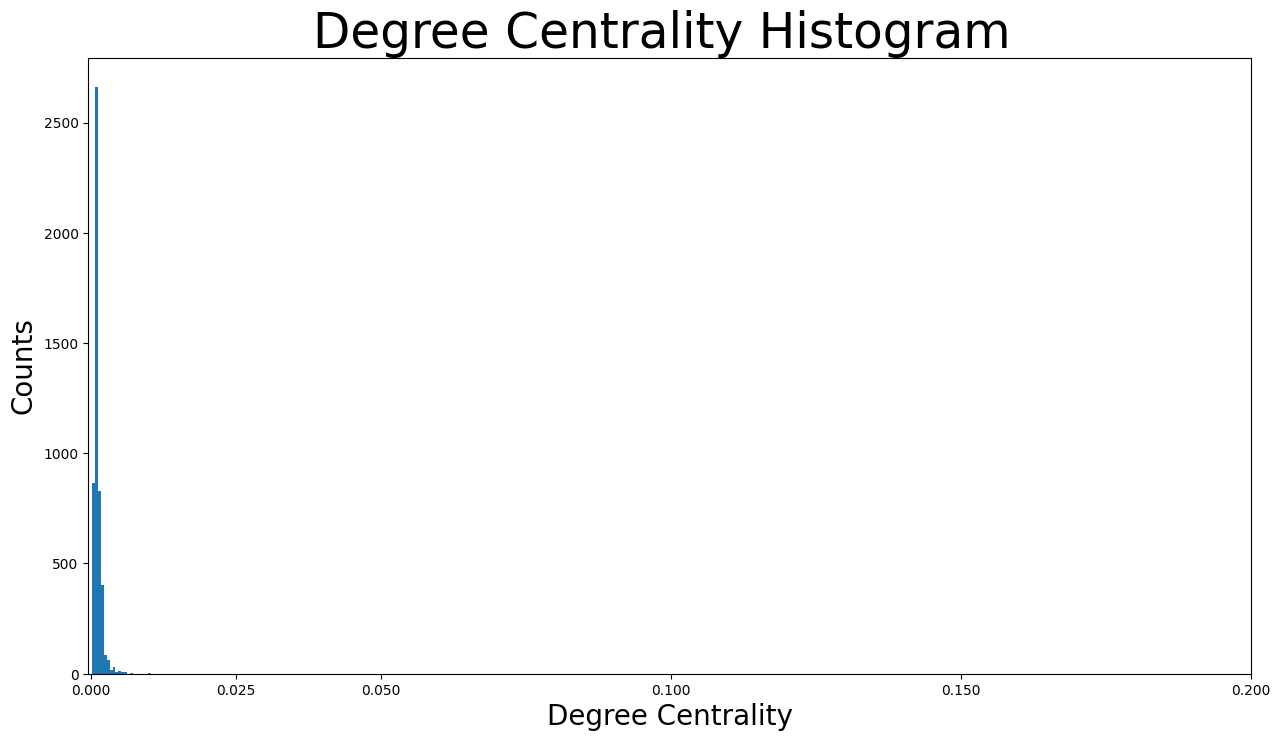

In [19]:
plt.figure(figsize=(15, 8))
plt.hist(degree_centrality.values(), bins=25)
plt.xticks(ticks=[0, 0.025, 0.05, 0.1, 0.15, 0.2])  # set the x axis ticks
plt.title("Degree Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Degree Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

Now let’s check the users with highest degree centralities from the size of their nodes:

(-1.1678708353638647,
 1.0600953260064125,
 -1.1488811865448951,
 1.20419232994318)

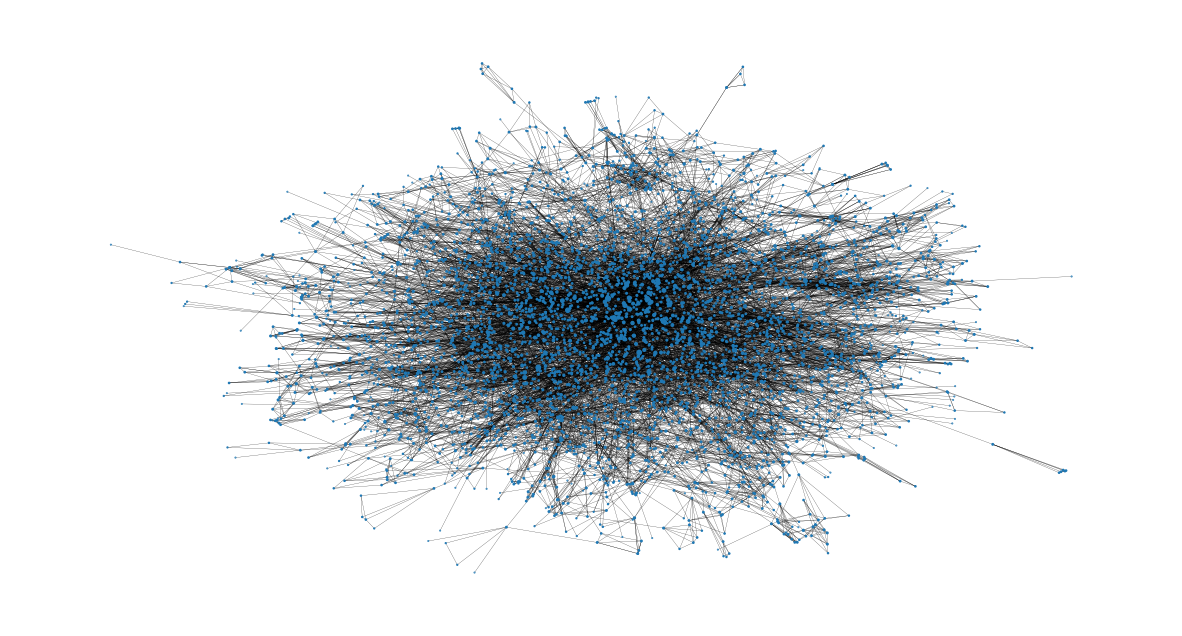

In [20]:
node_size = [
    v * 1000 for v in degree_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

## Betweenness Centrality
Betweenness centrality measures the number of times a node lies on the shortest path between other nodes, meaning it acts as a bridge. In detail, betweenness centrality of a node 
 is the percentage of all the shortest paths of any two nodes (apart from 
), which pass through 
. Specifically, in the facebook graph this measure is associated with the user’s ability to influence others. A user with a high betweenness centrality acts as a bridge to many users that are not friends and thus has the ability to influence them by conveying information (e.g. by posting something or sharing a post) or even connect them via the user’s circle (which would reduce the user’s betweeness centrality after).

- Now, the nodes with the 
 highest betweenness centralities will be calculated and shown with their centrality values:

In [21]:
betweenness_centrality = nx.centrality.betweenness_centrality(
    G
)  # save results in a variable to use again
(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(8, 0.17889677681664656),
 (18, 0.09884262596978535),
 (481, 0.08394860484845637),
 (302, 0.0722720186338093),
 (117, 0.06943862601389399),
 (93, 0.06381531412961122),
 (97, 0.06379312818881606),
 (33, 0.06367974919765888)]

Text(0, 0.5, 'Counts')

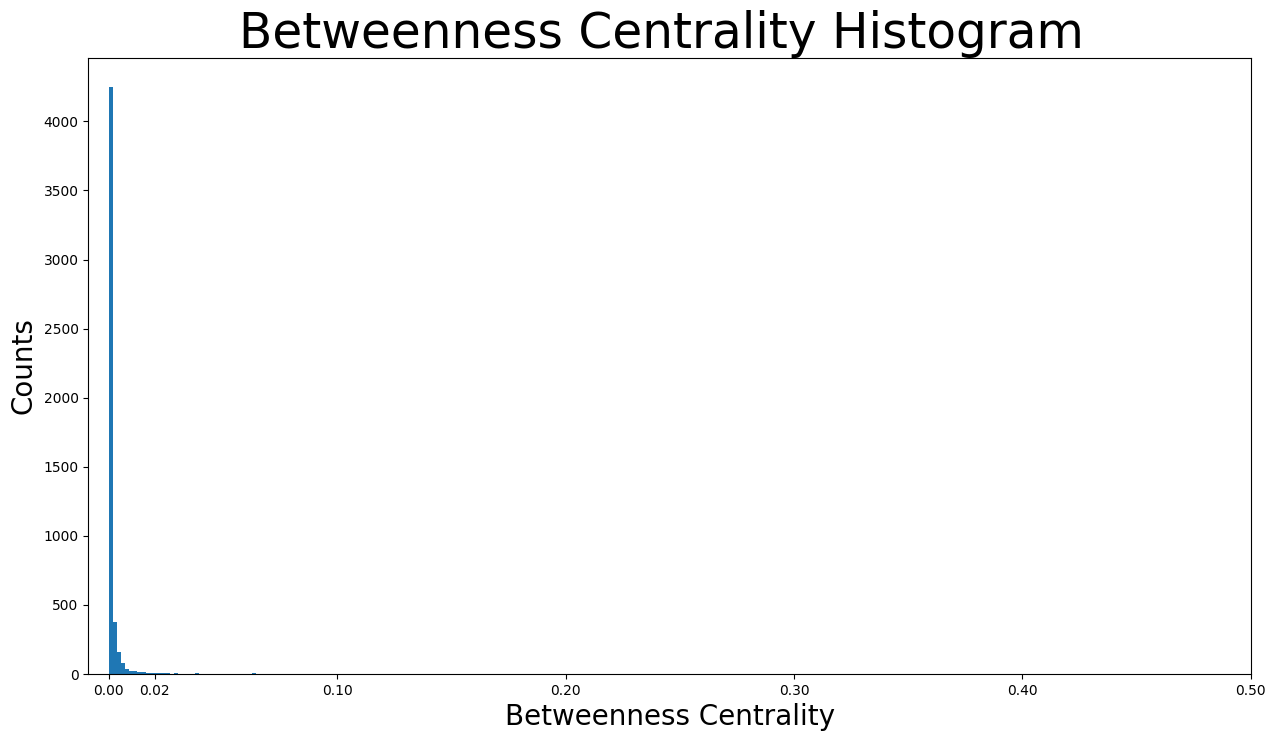

In [22]:
plt.figure(figsize=(15, 8))
plt.hist(betweenness_centrality.values(), bins=100)
plt.xticks(ticks=[0, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5])  # set the x axis ticks
plt.title("Betweenness Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Betweenness Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

(-1.1678708353638647,
 1.0600953260064125,
 -1.1488811865448951,
 1.20419232994318)

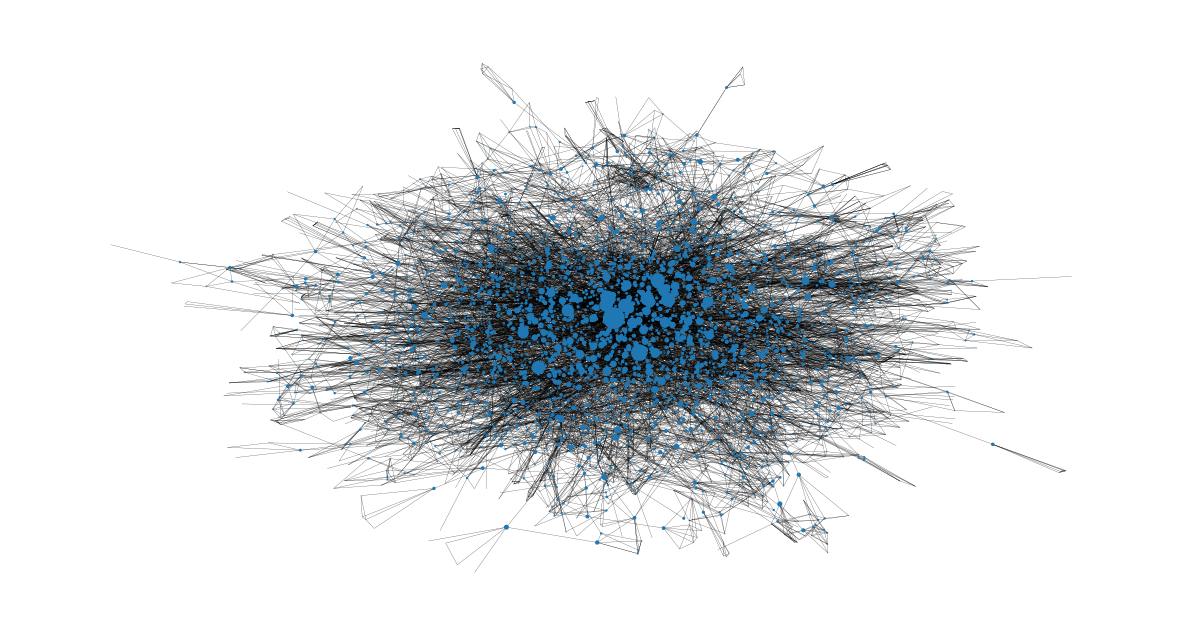

In [23]:
node_size = [
    v * 1200 for v in betweenness_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

## Closeness Centrality
Closeness centrality scores each node based on their ‘closeness’ to all other nodes in the network. For a node v
, its closeness centrality measures the average farness to all other nodes. In other words, the higher the closeness centrality of v
, the closer it is located to the center of the network.

The closeness centrality measure is very important for the monitoring of the spread of false information (e.g. fake news) or viruses (e.g. malicious links that gain control of the facebook account in this case). Let’s examine the example of fake news. If the user with the highest closeness centrality measure started spreading some fake news information (sharing or creating a post), the whole network would get missinformed the quickest possible. However, if a user with very low closeness centrality would try the same, the spread of the missinformation to the whole network would be much slower. That is because the false information would have to firstly reach a user with high closeness centrality that would spread it to many different parts of the network.

- The nodes with the highest closeness centralities will be found now:

In [24]:
closeness_centrality = nx.centrality.closeness_centrality(
    G
)  # save results in a variable to use again
(sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(8, 0.23301332836238234),
 (18, 0.21806445985433295),
 (481, 0.21602937999567942),
 (97, 0.2147674068983291),
 (21, 0.2135474502434441),
 (99, 0.21183747828665847),
 (302, 0.21018117617386187),
 (20, 0.20988120723670403)]

In [25]:
1 / closeness_centrality[107]

7.248799999999999

The distance from node 107
 to a random node is around two hops

Furthermore, the distribution of the closeness centralities:

Text(0, 0.5, 'Counts')

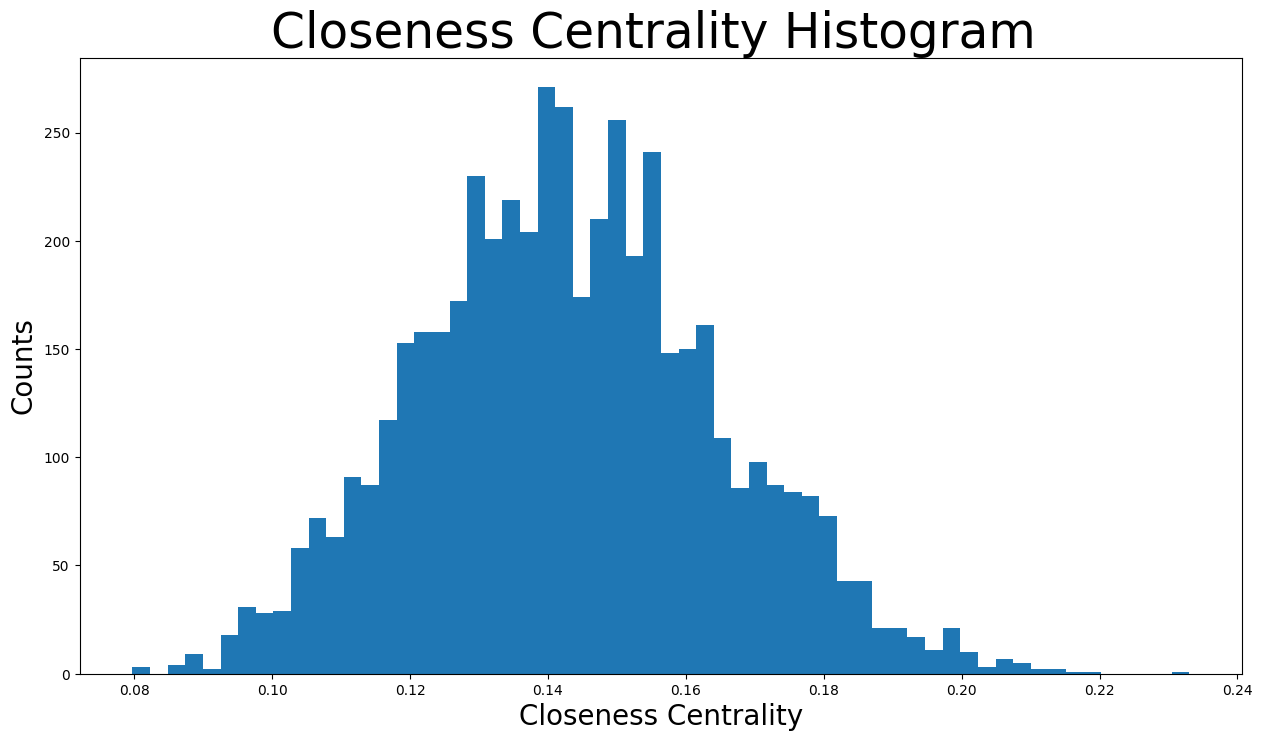

In [26]:
plt.figure(figsize=(15, 8))
plt.hist(closeness_centrality.values(), bins=60)
plt.title("Closeness Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Closeness Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

(-1.1678708353638647,
 1.0600953260064125,
 -1.1488811865448951,
 1.20419232994318)

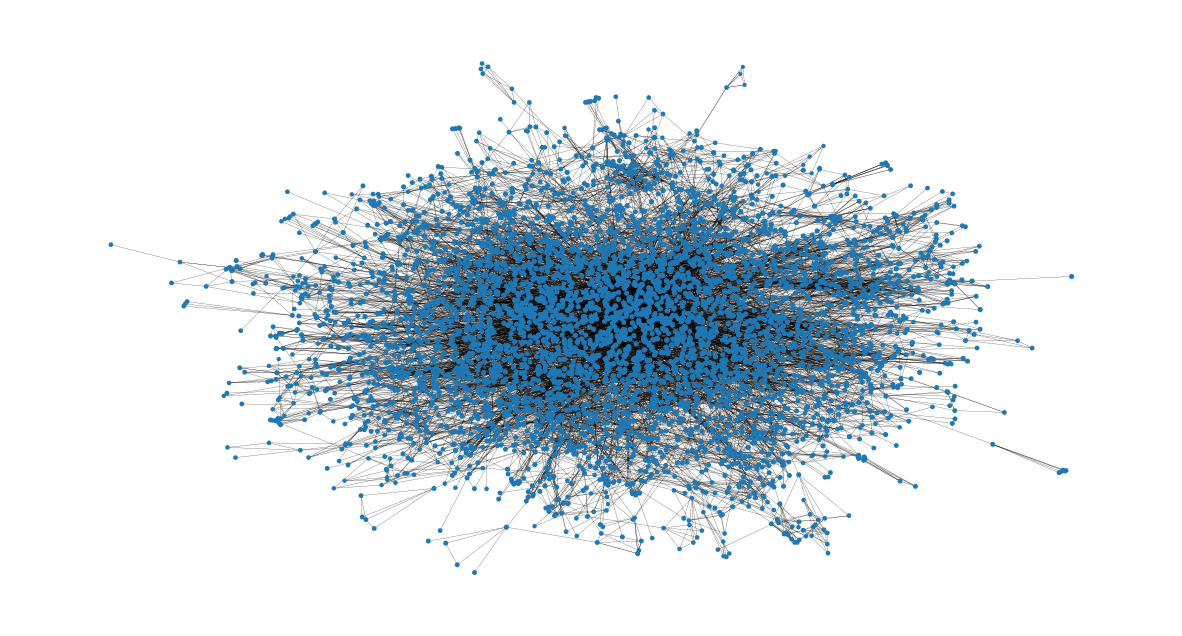

In [27]:
node_size = [
    v * 50 for v in closeness_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

## Clustering Effects
The clustering coefficient of a node v
 is defined as the probability that two randomly selected friends of v
 are friends with each other. As a result, the average clustering coefficient is the average of clustering coefficients of all the nodes. The closer the average clustering coefficient is to 1
, the more complete the graph will be because there’s just one giant component. Lastly, it is a sign of triadic closure because the more complete the graph is, the more triangles will usually arise.

In [29]:
nx.average_clustering(G)

0.4873880599591386

Now the clustering coefficient distribution will be displayed:

Text(0, 0.5, 'Counts')

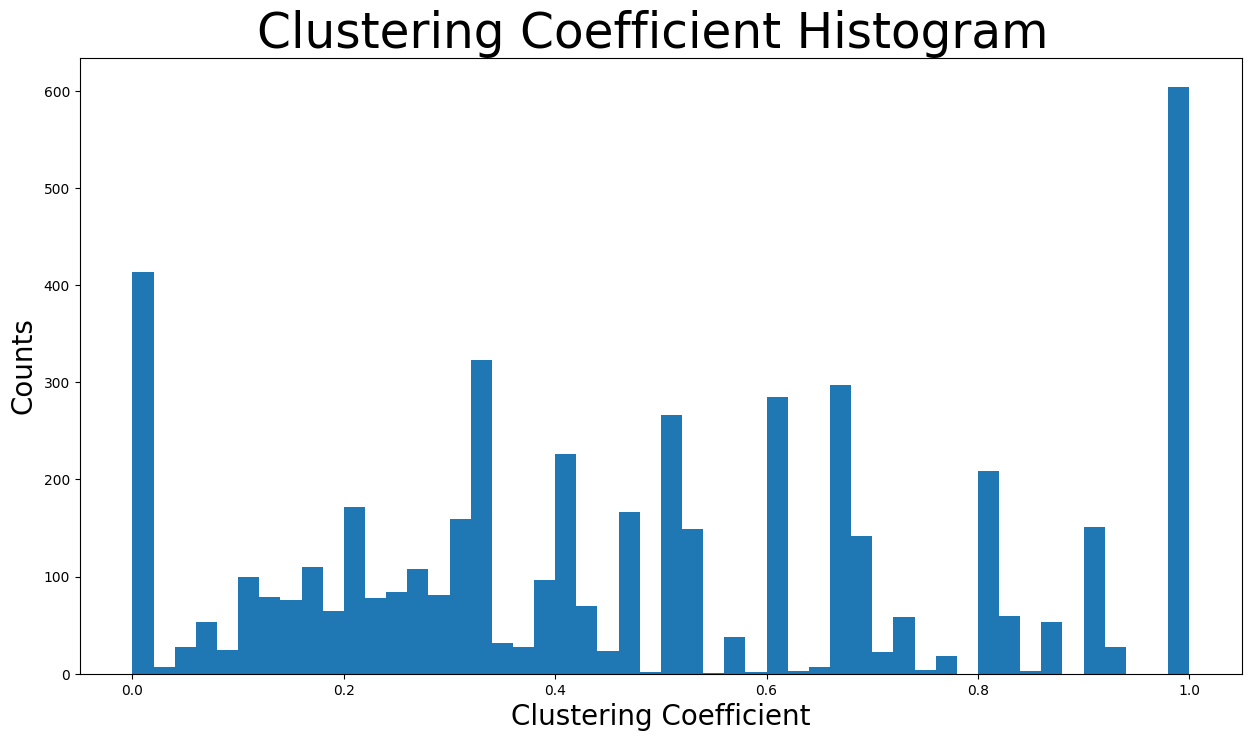

In [30]:
plt.figure(figsize=(15, 8))
plt.hist(nx.clustering(G).values(), bins=50)
plt.title("Clustering Coefficient Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Clustering Coefficient", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

In [31]:
triangles_per_node = list(nx.triangles(G).values())
sum(
    triangles_per_node
) / 3  # divide by 3 because each triangle is counted once for each node

12024.0

Now the average number of triangles that a node is a part of:

In [32]:
np.mean(triangles_per_node)

7.212957408518296

Due to having some nodes that belong to a great many triangles, the metric of median will give us a better understanding:

In [33]:
np.median(triangles_per_node)

6.0

## Bridges
First of all, an edge joining two nodes A and B in the graph is considered a bridge, if deleting the edge would cause A and B to lie in two different components. Now it is checked if there are any bridges in this network:

In [34]:
nx.has_bridges(G)

True

Actually, there are bridges in the network. Now the edges that are bridges will be saved in a list and the number of them is printed:

In [35]:
bridges = list(nx.bridges(G))
len(bridges)

222

The existence of so many bridges is due to the fact that this network only contains the spotlight nodes and the friends of them. As a result, some friends of spotlight nodes are only connected to a spotlight node, making that edge a bridge.

Also, the edges that are local bridges are saved in a list and their number is printed. In detaill, an edge joining two nodes C
 and D
 in a graph is a local bridge, if its endpoints C
 and D
 have no friends in common. Very importantly, an edge that is a bridge is also a local bridge. Thus, this list contains all the above bridges as well:

In [36]:
local_bridges = list(nx.local_bridges(G, with_span=False))
len(local_bridges)

2213

Showcasing the bridges and local bridges in the network now. The bridges can be seen with the red color and the local bridges with the green color. Black edges are neither local bridges nor bridges.

- It is clear that all the bridges concern nodes that are only connected to a spotlight node (have a degree of 1
)

(-1.1678708353638647,
 1.0600953260064125,
 -1.1488811865448951,
 1.20419232994318)

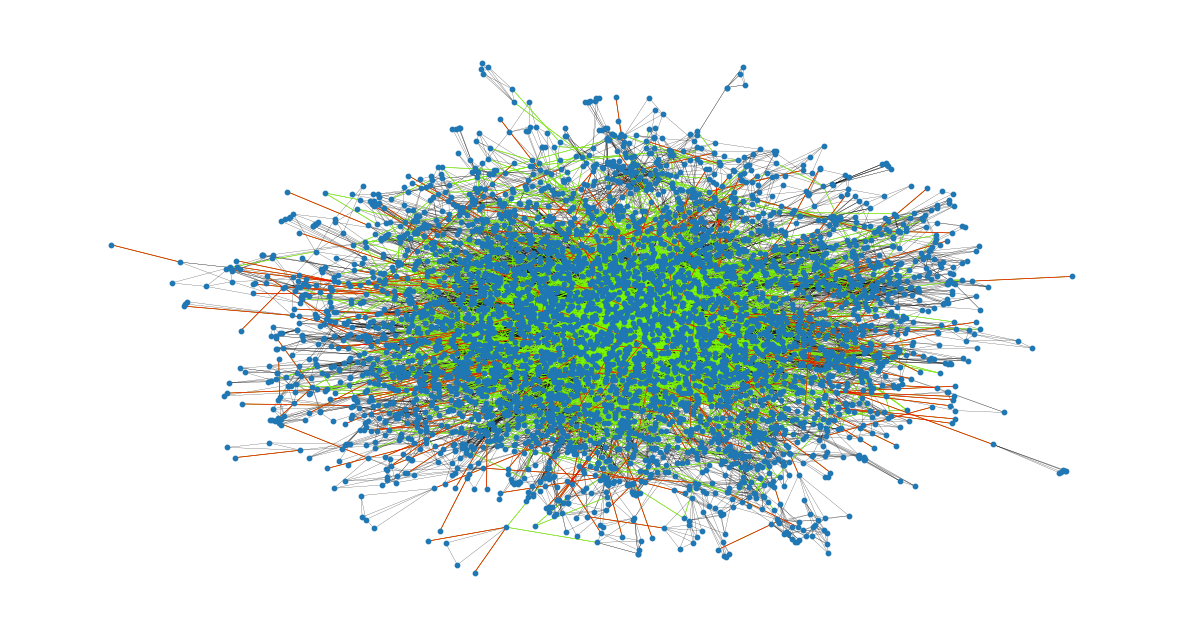

In [37]:
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=10, with_labels=False, width=0.15)
nx.draw_networkx_edges(
    G, pos, edgelist=local_bridges, width=0.5, edge_color="lawngreen"
)  # green color for local bridges
nx.draw_networkx_edges(
    G, pos, edgelist=bridges, width=0.5, edge_color="r"
)  # red color for bridges
plt.axis("off")

## Assortativity
Assortativity describes the preference for a network’s nodes to attach to others that are similar in some way.

The assortativity in terms of nodes degrees is found with two ways:

In [38]:
nx.degree_assortativity_coefficient(G)

0.09497626972985719

In [39]:
nx.degree_pearson_correlation_coefficient(
    G
)  # use the potentially faster scipy.stats.pearsonr function.

0.0949762697298621

## Network Communities
A community is a group of nodes, so that nodes inside the group are connected with many more edges than between groups. Two different algorithms will be used for communities detection in this network

- Firstly, a semi-synchronous label propagation method [1] is used to detect the communities.

This function determines by itself the number of communities that will be detected. Now the communities will be iterated through and a colors list will be created to contain the same color for nodes that belong to the same community. Also, the number of communities is printed:

In [42]:
colors = ["" for x in range(G.number_of_nodes())]  # initialize colors list
counter = 0
for com in nx.community.label_propagation_communities(G):
    color = "#%06X" % randint(0, 0xFFFFFF)  # creates random RGB color
    counter += 1
    for node in list(
        com
    ):  # fill colors list with the particular color for the community nodes
        colors[node] = color
counter

571

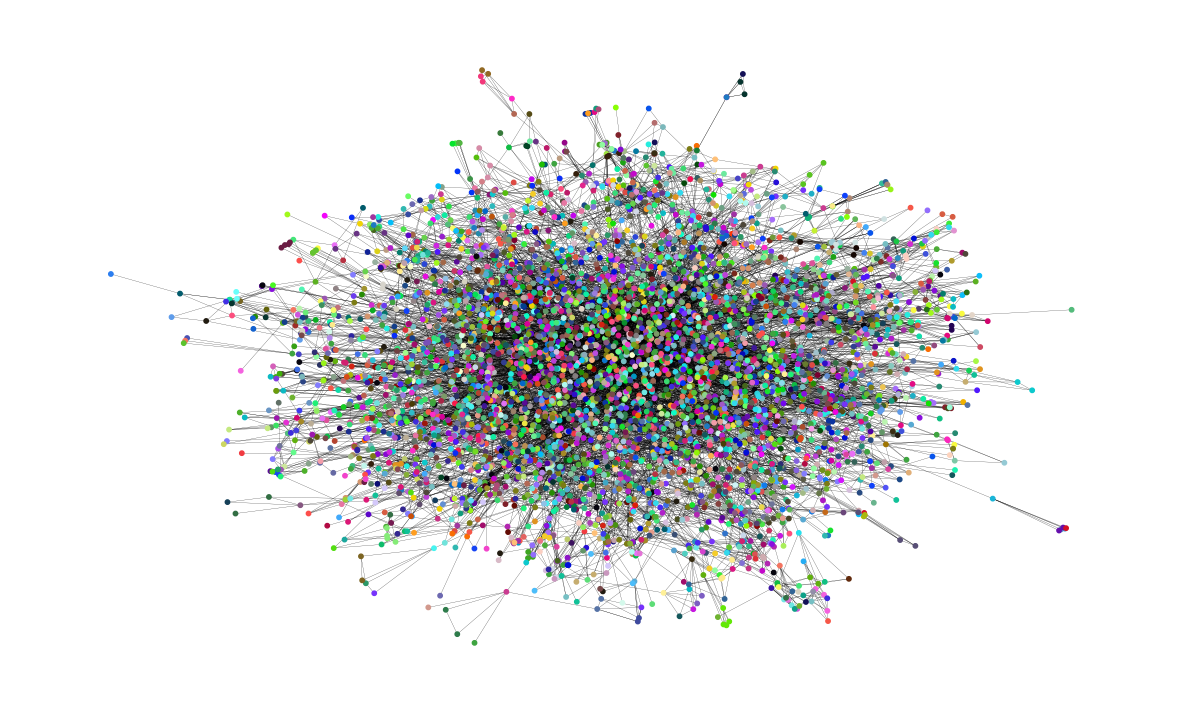

In [43]:
plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(
    G, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=colors
)

- Next, the asynchronous fluid communities algorithm is used.

With this function, we can decide the number of communities to be detected. Let’s say that 
 communities is the number we want. Again, the communities will be iterated through and a colors list will be created to contain the same color for nodes that belong to the same community.

In [44]:
colors = ["" for x in range(G.number_of_nodes())]
for com in nx.community.asyn_fluidc(G, 8, seed=0):
    color = "#%06X" % randint(0, 0xFFFFFF)  # creates random RGB color
    for node in list(com):
        colors[node] = color

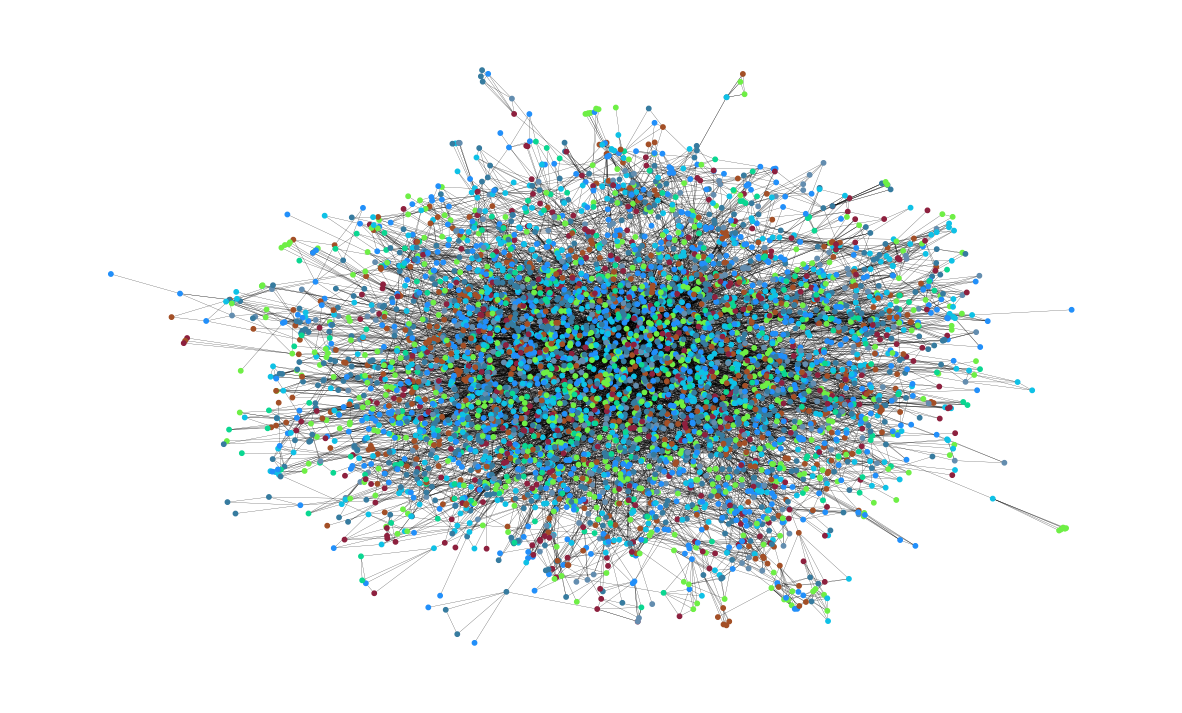

In [45]:
plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(
    G, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=colors
)

# Conclusion
As part of this practical, we developed a structure-based social media analytics model for Facebook, focusing on community detection and influence analysis. We started by collecting data using Facebook's Graph API, and then we used network analysis techniques to identify different communities within the Facebook network based on interactions between users. We also analyzed the influence of different users within the network, based on their centrality measures, such as degree, betweenness, and closeness.

Overall, this practical provided a good understanding of the importance of structure-based social media analytics in understanding user behavior and interactions on social media platforms. The techniques we learned can be applied to a wide range of social media platforms, enabling businesses to gain insights into their audiences and develop targeted marketing strategies based on their findings.